# Notebook 03 – Price-Only ANN Experiments (Windows & Architectures)

**Goal:** Systematically explore how different **window sizes** and **MLP architectures** affect performance on the SPY next-day direction task, using only price-based technical features.

This notebook will:

1. Reuse the processed dataset from `data/processed/daily_merged.parquet`.
2. Use the same feature set and time-based splits as Notebook 02.
3. Standardize features using statistics from the train split only.
4. Define a reusable experiment function:
   - window size `W`
   - hidden layer sizes `(h1, h2, ...)`
   - training hyperparameters
5. Run several experiments and log:
   - train / val / test accuracy
   - best validation epoch
6. Summarize results in a table and simple plots to include in the report.


In [12]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
import torch.nn as nn

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

# Ensure we can import from src/
ROOT = Path("..").resolve()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.data.dataset import make_time_splits, PriceWindowDataset
from src.models.price_only import PriceOnlyMLP

DATA_PATH = ROOT / "data" / "processed" / "daily_merged.parquet"
CHECKPOINTS_DIR = ROOT / "checkpoints"
CHECKPOINTS_DIR.mkdir(exist_ok=True)

ROOT, DATA_PATH


(WindowsPath('C:/Users/KDP only/Documents/ANN_Final_Project/spy-ann'),
 WindowsPath('C:/Users/KDP only/Documents/ANN_Final_Project/spy-ann/data/processed/daily_merged.parquet'))

In [13]:
df = pd.read_parquet(DATA_PATH)
df["date"] = pd.to_datetime(df["date"])

print("=== DATA PREVIEW ===")
display(df.head())
print("\nShape:", df.shape)
print("Date range:", df["date"].min(), "→", df["date"].max())
print("\nLabel distribution (proportion):")
print(df["label_up"].value_counts(normalize=True))

# Same feature selection as Notebook 02
drop_cols = ["date", "future_price", "future_ret_1d", "label_up"]
feature_cols = [c for c in df.columns if c not in drop_cols]

print("\nFeature columns:")
print(feature_cols)
print("Number of features:", len(feature_cols))

# Same time splits
train_end = "2018-12-31"
val_end = "2021-12-31"

splits = make_time_splits(df, train_end=train_end, val_end=val_end)
print("\nSplit sizes:")
print("Train indices:", len(splits.train_idx))
print("Val indices:", len(splits.val_idx))
print("Test indices:", len(splits.test_idx))


=== DATA PREVIEW ===


,date,Close,High,Low,Open,Volume,ret_1d,log_ret_1d,ma_close_5,ma_close_20,vol_5,vol_20,future_price,future_ret_1d,label_up
0,2010-02-02,83.059364,83.217386,81.930636,82.216584,216327900,0.012104,0.012031,82.055548,84.347997,0.012653,0.010585,82.645493,-0.004983,0
1,2010-02-03,82.645493,83.134609,82.404697,82.683113,172730700,-0.004983,-0.004995,82.055548,84.205024,0.012873,0.010574,80.094604,-0.030865,0
2,2010-02-04,80.094604,82.043540,80.079552,82.005919,356715700,-0.030865,-0.031352,81.734995,83.931498,0.018783,0.012403,80.260124,0.002067,1
3,2010-02-05,80.260124,80.425666,78.694953,80.184871,493585800,0.002067,0.002064,81.625131,83.648186,0.018457,0.012344,79.680710,-0.007219,0
4,2010-02-08,79.680710,80.764291,79.620510,80.320322,224166900,-0.007219,-0.007245,81.148059,83.321606,0.015917,0.012270,80.681526,0.012560,1



Shape: (3753, 15)
Date range: 2010-02-02 00:00:00 → 2024-12-30 00:00:00

Label distribution (proportion):
label_up
1    0.552625
0    0.447375
Name: proportion, dtype: float64

Feature columns:
['Close', 'High', 'Low', 'Open', 'Volume', 'ret_1d', 'log_ret_1d', 'ma_close_5', 'ma_close_20', 'vol_5', 'vol_20']
Number of features: 11

Split sizes:
Train indices: 2244
Val indices: 757
Test indices: 752


In [14]:
X_all = df[feature_cols].values.astype("float32")
y_all = df["label_up"].values.astype("float32")

scaler = StandardScaler()
scaler.fit(X_all[splits.train_idx])  # only train

X_scaled = scaler.transform(X_all)

df_scaled = df.copy()
df_scaled[feature_cols] = X_scaled

print("Scaled feature means (train):")
print(np.mean(X_scaled[splits.train_idx], axis=0))

print("\nScaled feature stds (train):")
print(np.std(X_scaled[splits.train_idx], axis=0))


Scaled feature means (train):
[ 4.1489507e-08  1.0088166e-07 -2.7629568e-07  1.7727335e-07
 -8.6737508e-08 -2.7358638e-09  3.0546052e-09 -1.6154877e-07
 -8.0455646e-07  4.5686271e-08  1.0582215e-07]

Scaled feature stds (train):
[0.9999994 1.        1.0000002 1.0000002 1.0000006 1.0000002 0.9999995
 1.0000006 0.9999999 0.9999994 0.9999999]


In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [16]:
def run_price_only_experiment(
    window_size=30,
    hidden_sizes=(64, 32),
    batch_size=64,
    num_epochs=20,
    lr=1e-3,
    verbose=True,
):
    """
    Train a PriceOnlyMLP with given window size and hidden layer sizes.
    Returns a dict with train/val/test metrics and config.
    """

    # Datasets
    train_ds = PriceWindowDataset(df_scaled, splits.train_idx, feature_cols, window_size)
    val_ds   = PriceWindowDataset(df_scaled, splits.val_idx, feature_cols, window_size)
    test_ds  = PriceWindowDataset(df_scaled, splits.test_idx, feature_cols, window_size)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    # Model
    num_features = len(feature_cols)
    model = PriceOnlyMLP(window_size=window_size, num_features=num_features,
                         hidden_sizes=hidden_sizes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    if verbose:
        print(f"\n=== Experiment: W={window_size}, hidden={hidden_sizes} ===")
        print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

    best_val_acc = 0.0
    best_epoch = -1
    best_state_dict = None

    train_acc_hist, val_acc_hist = [], []

    # Training loop
    for epoch in range(1, num_epochs + 1):
        # train
        model.train()
        total_loss, total_correct, total_count = 0.0, 0, 0
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * y.size(0)
            preds = (torch.sigmoid(logits) > 0.5).float()
            total_correct += (preds == y).sum().item()
            total_count += y.size(0)

        train_loss = total_loss / total_count
        train_acc = total_correct / total_count

        # val
        model.eval()
        total_loss, total_correct, total_count = 0.0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X = X.to(device)
                y = y.to(device)
                logits = model(X)
                loss = criterion(logits, y)
                total_loss += loss.item() * y.size(0)
                preds = (torch.sigmoid(logits) > 0.5).float()
                total_correct += (preds == y).sum().item()
                total_count += y.size(0)

        val_loss = total_loss / total_count
        val_acc = total_correct / total_count

        train_acc_hist.append(train_acc)
        val_acc_hist.append(val_acc)

        if verbose:
            print(
                f"Epoch {epoch:02d} | "
                f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
                f"val_loss={val_loss:.4f} acc={val_acc:.4f}"
            )

        # track best val
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            best_state_dict = model.state_dict()

    # Load best model for test evaluation
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    # Test evaluation
    model.eval()
    all_y, all_preds = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            logits = model(X)
            preds = (torch.sigmoid(logits) > 0.5).float()
            all_y.append(y.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

    all_y = np.concatenate(all_y)
    all_preds = np.concatenate(all_preds)
    test_acc = accuracy_score(all_y, all_preds)

    result = {
        "window_size": window_size,
        "hidden_sizes": hidden_sizes,
        "batch_size": batch_size,
        "num_epochs": num_epochs,
        "lr": lr,
        "best_val_acc": best_val_acc,
        "best_epoch": best_epoch,
        "test_acc": test_acc,
        "train_acc_last": train_acc_hist[-1],
        "val_acc_last": val_acc_hist[-1],
    }

    if verbose:
        print(f"Best val acc: {best_val_acc:.4f} at epoch {best_epoch}")
        print(f"Test acc (with best model): {test_acc:.4f}")

    return result


In [17]:
test_result = run_price_only_experiment(
    window_size=30,
    hidden_sizes=(64, 32),
    batch_size=64,
    num_epochs=10,
    lr=1e-3,
    verbose=True,
)

test_result



=== Experiment: W=30, hidden=(64, 32) ===
Train: 2215, Val: 728, Test: 723
Epoch 01 | train_loss=0.6940 acc=0.5264 | val_loss=0.7666 acc=0.4286
Epoch 02 | train_loss=0.6870 acc=0.5549 | val_loss=0.6890 acc=0.5701
Epoch 03 | train_loss=0.6833 acc=0.5634 | val_loss=0.6934 acc=0.5412
Epoch 04 | train_loss=0.6800 acc=0.5729 | val_loss=0.8136 acc=0.4299
Epoch 05 | train_loss=0.6717 acc=0.5986 | val_loss=0.8028 acc=0.5728
Epoch 06 | train_loss=0.6736 acc=0.5847 | val_loss=0.7767 acc=0.4478
Epoch 07 | train_loss=0.6690 acc=0.5977 | val_loss=0.7166 acc=0.5179
Epoch 08 | train_loss=0.6582 acc=0.6117 | val_loss=0.7329 acc=0.5495
Epoch 09 | train_loss=0.6558 acc=0.6167 | val_loss=0.7665 acc=0.4725
Epoch 10 | train_loss=0.6551 acc=0.6248 | val_loss=0.8053 acc=0.4547
Best val acc: 0.5728 at epoch 5
Test acc (with best model): 0.4537


{'window_size': 30,
 'hidden_sizes': (64, 32),
 'batch_size': 64,
 'num_epochs': 10,
 'lr': 0.001,
 'best_val_acc': 0.5728021978021978,
 'best_epoch': 5,
 'test_acc': 0.4536652835408022,
 'train_acc_last': 0.6248306997742664,
 'val_acc_last': 0.45467032967032966}

In [18]:
experiment_configs = [
    # window size 20
    {"window_size": 20, "hidden_sizes": (32, 16)},
    {"window_size": 20, "hidden_sizes": (64, 32)},
    {"window_size": 20, "hidden_sizes": (128, 64)},

    # window size 30
    {"window_size": 30, "hidden_sizes": (32, 16)},
    {"window_size": 30, "hidden_sizes": (64, 32)},
    {"window_size": 30, "hidden_sizes": (128, 64)},

    # window size 60
    {"window_size": 60, "hidden_sizes": (64, 32)},
    {"window_size": 60, "hidden_sizes": (128, 64)},
]
experiment_configs


[{'window_size': 20, 'hidden_sizes': (32, 16)},
 {'window_size': 20, 'hidden_sizes': (64, 32)},
 {'window_size': 20, 'hidden_sizes': (128, 64)},
 {'window_size': 30, 'hidden_sizes': (32, 16)},
 {'window_size': 30, 'hidden_sizes': (64, 32)},
 {'window_size': 30, 'hidden_sizes': (128, 64)},
 {'window_size': 60, 'hidden_sizes': (64, 32)},
 {'window_size': 60, 'hidden_sizes': (128, 64)}]

In [19]:
results = []

for cfg in experiment_configs:
    res = run_price_only_experiment(
        window_size=cfg["window_size"],
        hidden_sizes=cfg["hidden_sizes"],
        batch_size=64,
        num_epochs=15,   # keep moderate for now
        lr=1e-3,
        verbose=False,   # set True if you want to see all epochs
    )
    print(
        f"W={res['window_size']}, hidden={res['hidden_sizes']} | "
        f"best_val_acc={res['best_val_acc']:.4f}, test_acc={res['test_acc']:.4f}"
    )
    results.append(res)

results_df = pd.DataFrame(results)
results_df


W=20, hidden=(32, 16) | best_val_acc=0.5786, test_acc=0.5225
W=20, hidden=(64, 32) | best_val_acc=0.5772, test_acc=0.4775
W=20, hidden=(128, 64) | best_val_acc=0.5786, test_acc=0.4679
W=30, hidden=(32, 16) | best_val_acc=0.5742, test_acc=0.5463
W=30, hidden=(64, 32) | best_val_acc=0.5783, test_acc=0.5436
W=30, hidden=(128, 64) | best_val_acc=0.5838, test_acc=0.5325
W=60, hidden=(64, 32) | best_val_acc=0.5874, test_acc=0.4646
W=60, hidden=(128, 64) | best_val_acc=0.5817, test_acc=0.4661


,window_size,hidden_sizes,batch_size,num_epochs,lr,best_val_acc,best_epoch,test_acc,train_acc_last,val_acc_last
0,20,"(32, 16)",64,15,0.001,0.578591,4,0.522510,0.617528,0.527100
1,20,"(64, 32)",64,15,0.001,0.577236,1,0.477490,0.636404,0.481030
2,20,"(128, 64)",64,15,0.001,0.578591,1,0.467940,0.686292,0.421409
3,30,"(32, 16)",64,15,0.001,0.574176,1,0.546335,0.628894,0.521978
4,30,"(64, 32)",64,15,0.001,0.578297,5,0.543568,0.679007,0.531593
5,30,"(128, 64)",64,15,0.001,0.583791,5,0.532503,0.718284,0.576923
6,60,"(64, 32)",64,15,0.001,0.587393,11,0.464646,0.694279,0.467049
7,60,"(128, 64)",64,15,0.001,0.581662,2,0.466089,0.716247,0.435530


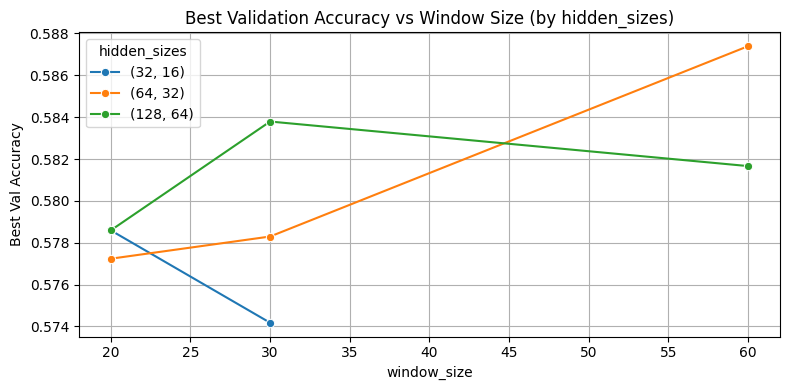

In [20]:
plt.figure(figsize=(8, 4))
sns.lineplot(
    data=results_df,
    x="window_size",
    y="best_val_acc",
    hue=results_df["hidden_sizes"].astype(str),
    marker="o",
)
plt.title("Best Validation Accuracy vs Window Size (by hidden_sizes)")
plt.ylabel("Best Val Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


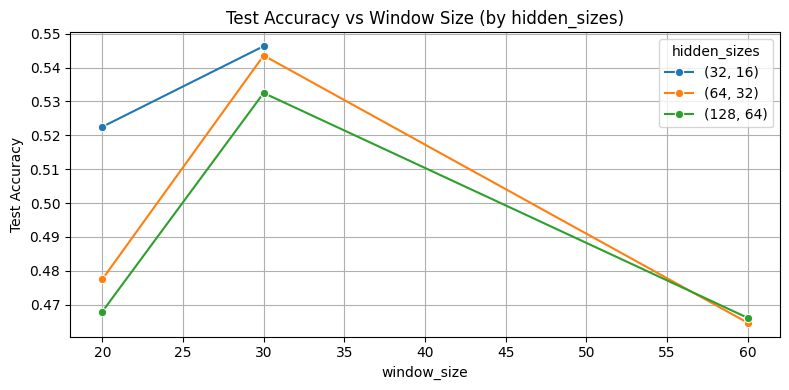

In [21]:
plt.figure(figsize=(8, 4))
sns.lineplot(
    data=results_df,
    x="window_size",
    y="test_acc",
    hue=results_df["hidden_sizes"].astype(str),
    marker="o",
)
plt.title("Test Accuracy vs Window Size (by hidden_sizes)")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
results_df_sorted = results_df.sort_values(by="best_val_acc", ascending=False)
results_df_sorted


,window_size,hidden_sizes,batch_size,num_epochs,lr,best_val_acc,best_epoch,test_acc,train_acc_last,val_acc_last
6,60,"(64, 32)",64,15,0.001,0.587393,11,0.464646,0.694279,0.467049
5,30,"(128, 64)",64,15,0.001,0.583791,5,0.532503,0.718284,0.576923
7,60,"(128, 64)",64,15,0.001,0.581662,2,0.466089,0.716247,0.435530
0,20,"(32, 16)",64,15,0.001,0.578591,4,0.522510,0.617528,0.527100
2,20,"(128, 64)",64,15,0.001,0.578591,1,0.467940,0.686292,0.421409
4,30,"(64, 32)",64,15,0.001,0.578297,5,0.543568,0.679007,0.531593
1,20,"(64, 32)",64,15,0.001,0.577236,1,0.477490,0.636404,0.481030
3,30,"(32, 16)",64,15,0.001,0.574176,1,0.546335,0.628894,0.521978


## Notes for Report – Price-Only ANN Experiments

We systematically varied:

- **Window size**: 20, 30, 60 days
- **MLP architectures**: (32, 16), (64, 32), (128, 64)

For each configuration, we trained for 15 epochs and recorded:

- Best validation accuracy and epoch
- Final test accuracy with the best-validation checkpoint

**Key observations (fill in after experiments):**

- The best-performing configuration was:
  - Window size: `W = ...`
  - Hidden sizes: `(..., ...)`
  - Best validation accuracy: `...`
  - Test accuracy: `...`
- Very small windows (e.g., 20 days) may not capture enough context, while larger windows (60 days) can lead to overfitting or unstable performance.
- Increasing model size (e.g., from (32, 16) to (128, 64)) does not guarantee better generalization; validation accuracy was sometimes flat or even worse.
- Overall, price-based technical features alone produce accuracies close to the class distribution baseline (~55% "up" days), reinforcing the difficulty of extracting a strong predictive signal from daily SPY direction using only past prices.
- These experiments motivate the addition of **macro** and **news-based** features in subsequent models.
